In [1]:
import numpy as np
from model import Actor, Critic
from utils import get_rho_from_u_at_t, plot_3d, get_rho_from_u
import torch
import matplotlib.pyplot as plt

In [2]:
n_cell = 8
T_terminal = 1
delta_T = 1 / n_cell
T = int(T_terminal / delta_T)

## Use initial rho to generate rho

/Users/ninolau/Documents/GitHub/speed_control/utils.py:230: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


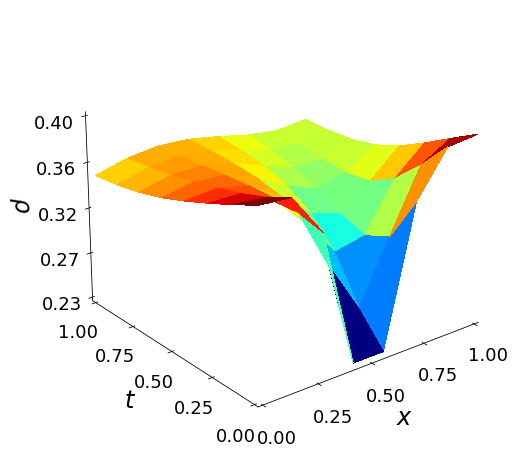

In [3]:
us = np.loadtxt(f"data/u-non-sep.txt")
T = n_cell * T_terminal
rhos, rhos_t = np.zeros((n_cell, T)), np.loadtxt(f"data/rho-non-sep.txt")[:, 0]
for t in range(T):
    rhos[:, t] = rhos_t[:]
    rhos_t = get_rho_from_u_at_t(n_cell, rhos_t, us[:, t])

plot_3d(n_cell, T_terminal, rhos, r"$\rho$")
plt.show()

---

## Use terminal V to generate V

In [4]:
list(range(T-1, -1, -1))

[7, 6, 5, 4, 3, 2, 1, 0]

In [5]:
us = np.loadtxt(f"data/u-non-sep.txt")
rhos = np.loadtxt(f"data/rho-non-sep.txt")
Vs, Vs_t = np.zeros((n_cell, T)), np.loadtxt(f"data/V-non-sep.txt")[:, -1]

In [6]:
for t in range(T - 1, -1, -1):
    reward = delta_T * (0.5 * us[:, t]** 2 + rhos[:, t] * us[:, t] - us[:, t])
    Vss_t = np.zeros(Vs_t.shape)
    Vss_t[:-1] = Vs_t[1:]
    Vss_t[-1] = Vs_t[0]
    Vs[:, t] = (1 - us[:, t]) * Vs_t + us[:, t] * Vss_t + reward
    Vs_t = Vs[:, t]
    
# plot_3d(n_cell, T_terminal, Vs, "V") # should be -.3-0
# plot_3d(n_cell, T_terminal, np.loadtxt(f"data/V-non-sep.txt")[:, :8], "V") # this is incorrect

---

## Use rho to generate u 

In [8]:
rhos = np.loadtxt(f"data/rho-non-sep.txt")
# rhos_next = np.zeros((8, 8))
# rhos_next[:, :-1] = rhos[:, 1:]
# rhos_next[:, -1] = get_rho_from_u_at_t(n_cell, rhos[:, -1], us[:, -1])

us = np.loadtxt(f"data/u-non-sep.txt")
Vs = np.loadtxt(f"data/V-non-sep.txt")[:, :-1]
Vs_next = np.zeros((8 ,8))
Vs_next[:, :-1] = Vs[:, 1:]
reward = sum(delta_T * rhos[:, -1] * (0.5 * us[:, -1] ** 2 + rhos[:, -1] * us[:, -1] - us[:, -1]))
Vs_next[:, -1] = Vs[:, -1] + reward

In [9]:
actor = Actor(n_cell)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)

In [10]:
# train actor
rhos = torch.tensor(rhos, requires_grad=True)
Vs, Vs_next = torch.tensor(Vs, requires_grad=True), torch.tensor(Vs_next, requires_grad=True)
for _ in range(2000):
    speeds = actor.forward(rhos)
    advantages = torch.sum(delta_T * rhos * (0.5 * speeds ** 2 + rhos * speeds - speeds), 0) \
                 + torch.reshape(torch.sum(Vs_next - Vs, 0), (T, 1))
    policy_loss = advantages.mean()
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()

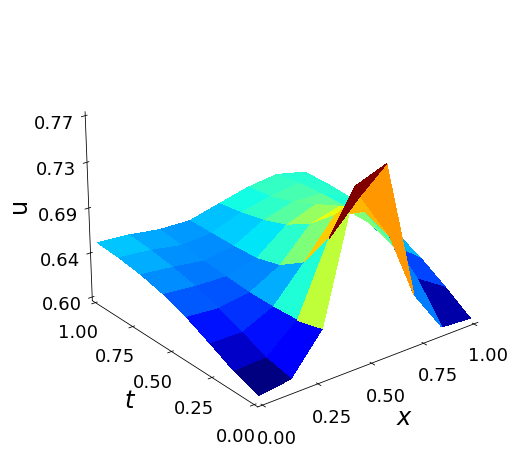

In [11]:
plot_3d(n_cell, T_terminal, speeds.detach().numpy(), "u")
plt.show()

---